# Leydig lineage - PLOTS, DEG and TF activities

In [1]:
library(Seurat)
library(dplyr)
library(RColorBrewer)
library(destiny, quietly = TRUE)
library(gam)
library(harmony)
library(ggplot2)
library(pheatmap)
library(cowplot)
library(SoupX)
# source('G_lib_TFacts.r')

luz_colors = c('#c466b0', 
               '#779eed', '#aad3f2', '#71a2c7', '#60bddb',   '#70ccbe', 
               '#7b9e99', '#91bd80', '#bdb380',  '#d4db81',  '#dbc381', '#ebd3c3', 
               '#edb7b7', '#d9abb7', '#e08b8b',  '#d96884', '#e64e74', '#d9a5c3', '#cc8fdb')

colors = c(luz_colors, 
           brewer.pal(n=12, name = 'Paired'), 
           brewer.pal(n=8, name = 'Set2'),
          brewer.pal(n=8, name = 'Set3'),
          brewer.pal(n=8, name = 'Accent'),
          brewer.pal(n=8, name = 'Pastel1'))

def_colors = list( reds = luz_colors[13:length(luz_colors) ],
                 yellows = luz_colors[7:12],
                 blues = luz_colors[2:6],
                 greys = c('#e8e8e8', '#b5b5b5', '#a6a6a6') )

col_dot = c('grey90',  brewer.pal(n = 9, name = 'Reds')[7])

downsample_data = function(anndataO, var = 'annotated_clusters', N=200){
    samples = list()
    for (cl in unique(anndataO@meta.data[,var]) ){
        cells = colnames(anndataO)[ anndataO@meta.data[,var] == cl ]
        samples[[cl]] = cells
        if( length(cells) > N )
            samples[[cl]] = sample(cells, size = N, replace = F)
    }
    anndataO = subset(anndataO, cells = unlist(samples))
    
    gene_counts = tabulate(anndataO@assays$RNA@counts@i + 1)
    anndataO = subset(anndataO, features = names(gene_counts)[ gene_counts > 3 ] )
    
    return(anndataO)
}



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: splines

Loading required package: foreach

Loaded gam 1.20


Loading required package: Rcpp



In [2]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS:   /home/jovyan/my-conda-envs/R_Seurat3/lib/libblas.so.3.8.0
LAPACK: /home/jovyan/my-conda-envs/R_Seurat3/lib/liblapack.so.3.8.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] splines   stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] SoupX_1.5.0        cowplot_1.1.1      pheatmap_1.0.12    ggplot2_3.3.3     
 [5] harmony_1.0        Rcpp_1.0.6         gam_1.20           foreach_1.5.1     
 [9] destiny_3.4.0      RColorBrewer_1.1-2 dplyr_1.0.5        Seurat_3.

In [3]:
markers = list( 
#     'lineage' = c('WT1', 'NR5A1', 'GATA4', 'LHX9'),
               'Fetal Leydig' = c('FDX1','HHIP', 'INSL3', 'PTCH1', 'PTCH2'),
                'ExM' = c('ACTA2', 'FN1', 'MDFI', 'MFAP4', 'NID1'),
                'Steroidogenic' = c('CYP17A1', 'HSD3B2',  'GSTA3', 'TM7SF2')
)
unlist(markers)[ which(duplicated(unlist(markers))) ]

named character(0)

# Load processed object

In [4]:
anndataO = readRDS('/nfs/team292/lg18/with_valentina/Leydig.rds')

## Format metadata

In [5]:
levels(Idents(anndataO))
anndataO = subset(anndataO, cells = colnames(anndataO)[ ! Idents(anndataO) %in% c('doublet', 'lowQC', 'FetalLeydig_cycling', 'FetalLeydig_early') ] )

[1] "FetalLeydig_ExM"     "FetalLeydig_Ster"    "FetalLeydig_cycling"
[4] "FetalLeydig_early"   "lowQC"

In [6]:
Idents(anndataO) = factor(anndataO$annotated_clusters, levels = c('FetalLeydig_ExM', 'FetalLeydig_Ster') )
anndataO@meta.data$annotated_clusters = Idents(anndataO)

# Plots supplementary

In [7]:
mycolors = c(def_colors$blues)

In [8]:
mycolors

[1] "#779eed" "#aad3f2" "#71a2c7" "#60bddb" "#70ccbe"

In [9]:
# DimPlot(anndataO, reduction = "umap", label = T, pt.size =0.5, 
#         cols = mycolors) + 
#         ggtitle('annotated cell states')+ 
#         theme(panel.border = element_rect(colour = "black", fill=NA, size=1))
# ggsave(filename = paste0('figures-Leydig/0_FS2_umap_annotatedLowQC.pdf'), dpi = 300, width = 6.5, height = 5)

In [10]:
# VlnPlot(anndataO, c('scrublet.score'), 
#         pt.size = 0.2,
#         ncol = 1, 
#         cols = mycolors)
# ggsave(filename = paste0('figures-Leydig/0_FS2_boxplot_scublet.pdf'), dpi = 300, width = 6.5, height = 5)

# VlnPlot(anndataO, c('nCount_RNA'), 
#         pt.size = 0.2,
#         ncol = 1, 
#         cols = mycolors)
# ggsave(filename = paste0('figures-Leydig/0_FS2_boxplot_nCount_RNA.pdf'), dpi = 300, width = 6.5, height = 5)

# TF-IDF markers in high resolution populations

In [11]:
# df_tfIDF = quickMarkers(toc = anndataO@assays$RNA@counts, clusters = anndataO$annotated_clusters, N = 100000)

# write.csv(df_tfIDF, file = 'figures-Leydig/0_FS2_table_TFIDF_annotatedLowQC.csv', quote = F, row.names = F)

# df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = levels(anndataO$annotated_clusters) )
# DEGs_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
#   group_by(cluster) %>%
#   group_map(~ head(.x, 15L)$gene) %>%
#   unlist(.)

In [12]:
# DotPlot(anndataO, features = unique(DEGs_tfIDF), group.by = 'annotated_clusters') + RotatedAxis() + scale_fill_brewer(palette = 'Reds') +
# ggsave(filename = paste0('figures-Leydig/0_FS2_dotplot_TFIDF_annotatedLowQC.pdf'), dpi = 75, height = 5, width = 45)

# Exclude non-confident cells

In [13]:
# anndataO = subset(anndataO, cells = colnames(anndataO)[ ! Idents(anndataO) %in% c('doublet', 'lowQC') ] )

## Plots

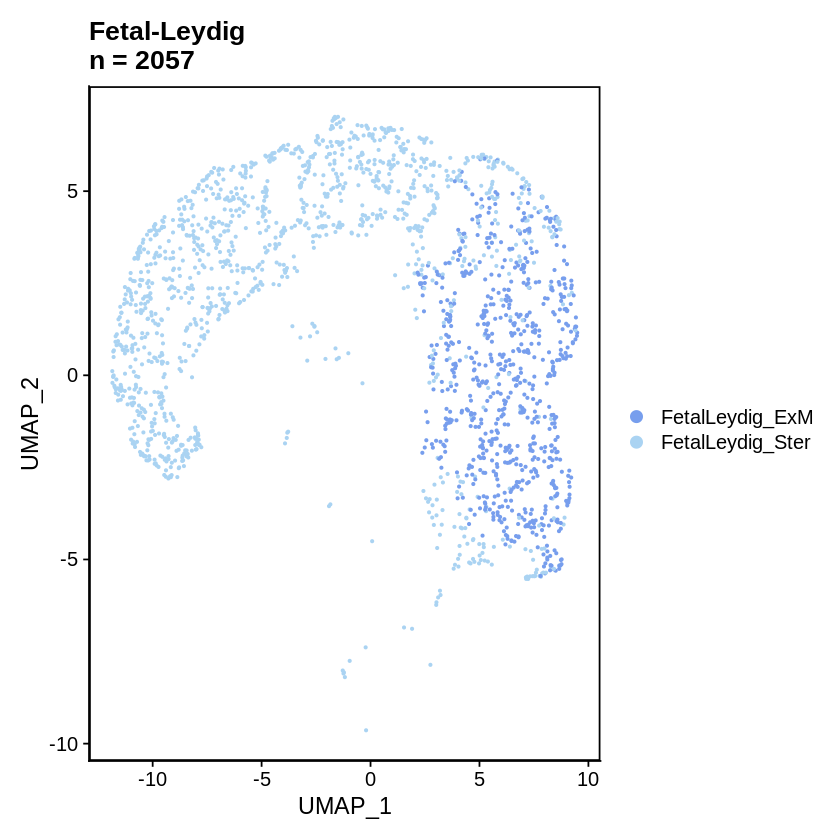

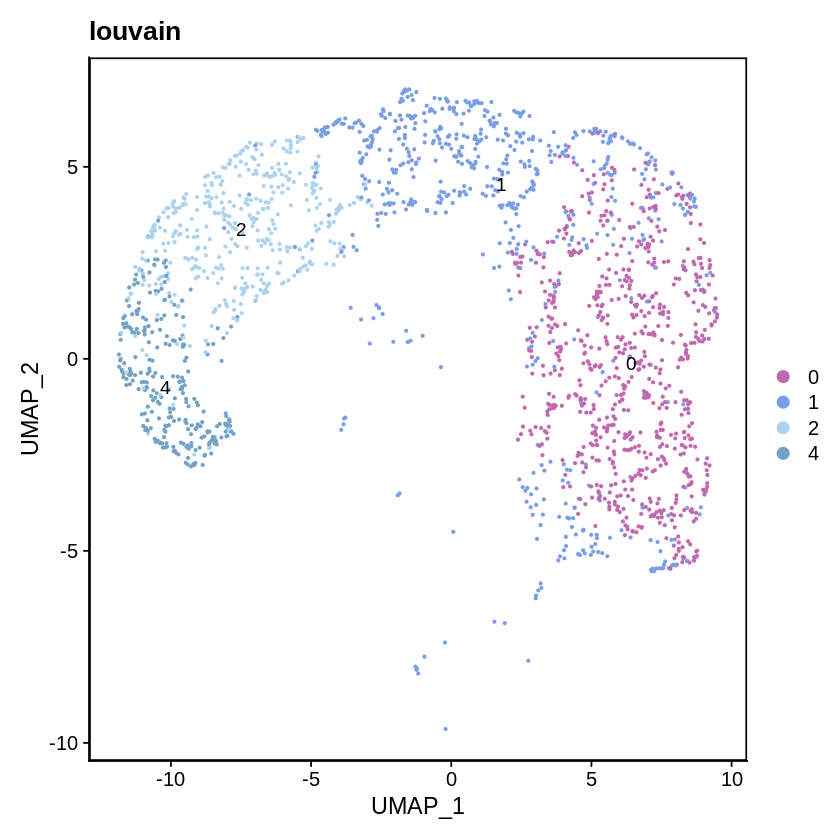

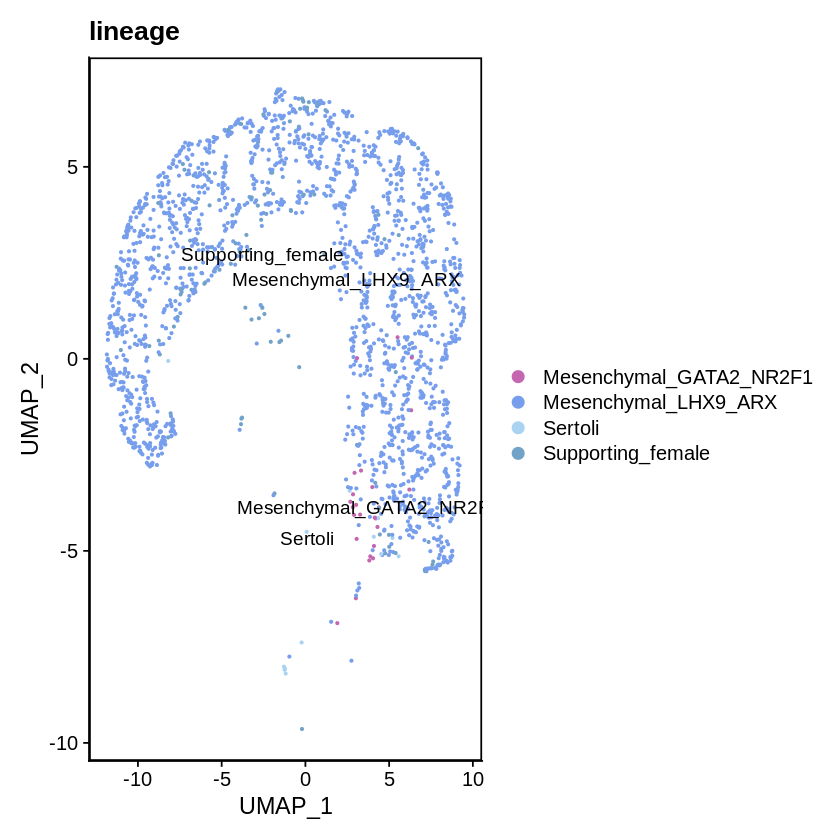

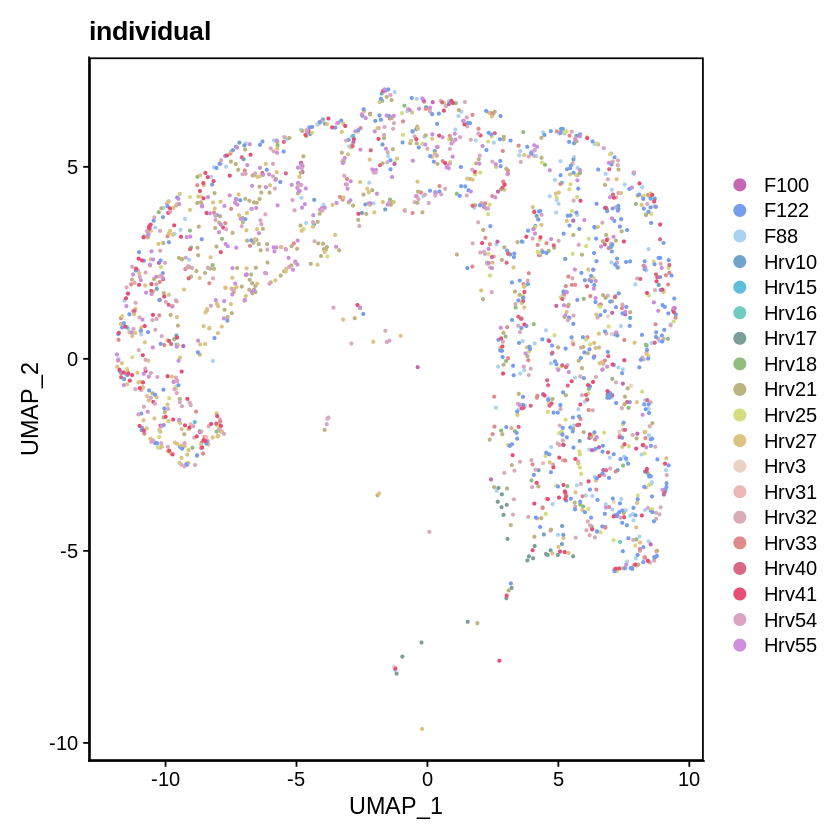

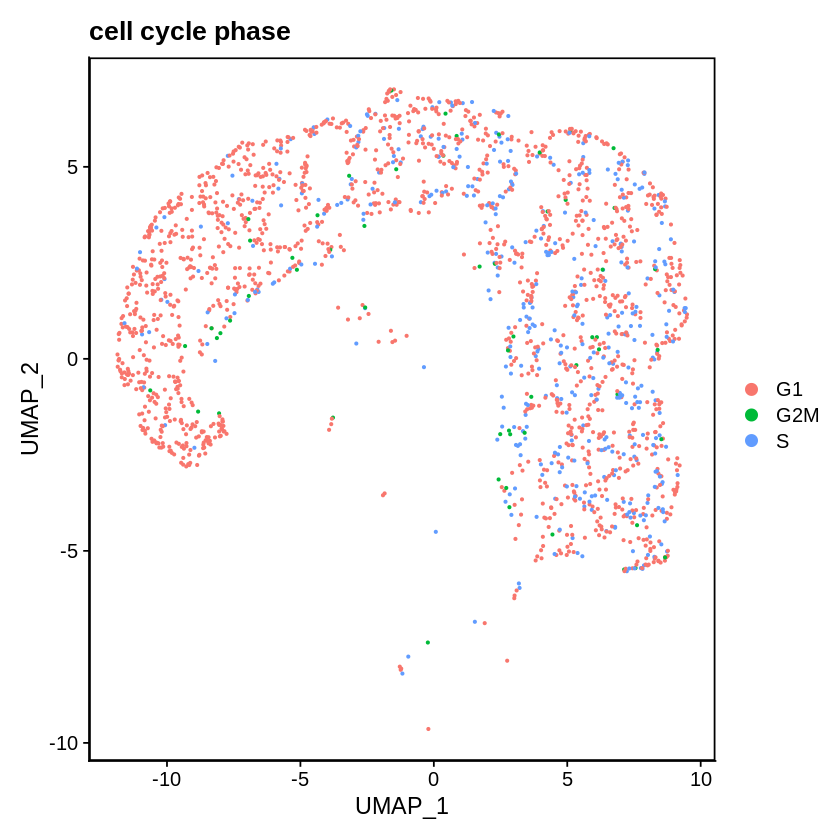

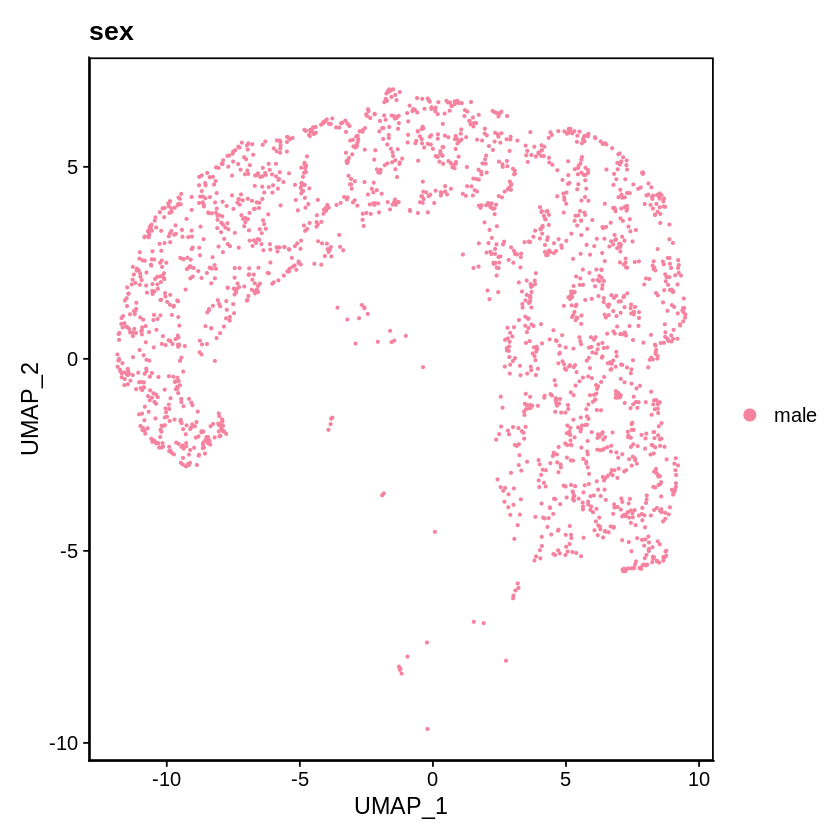

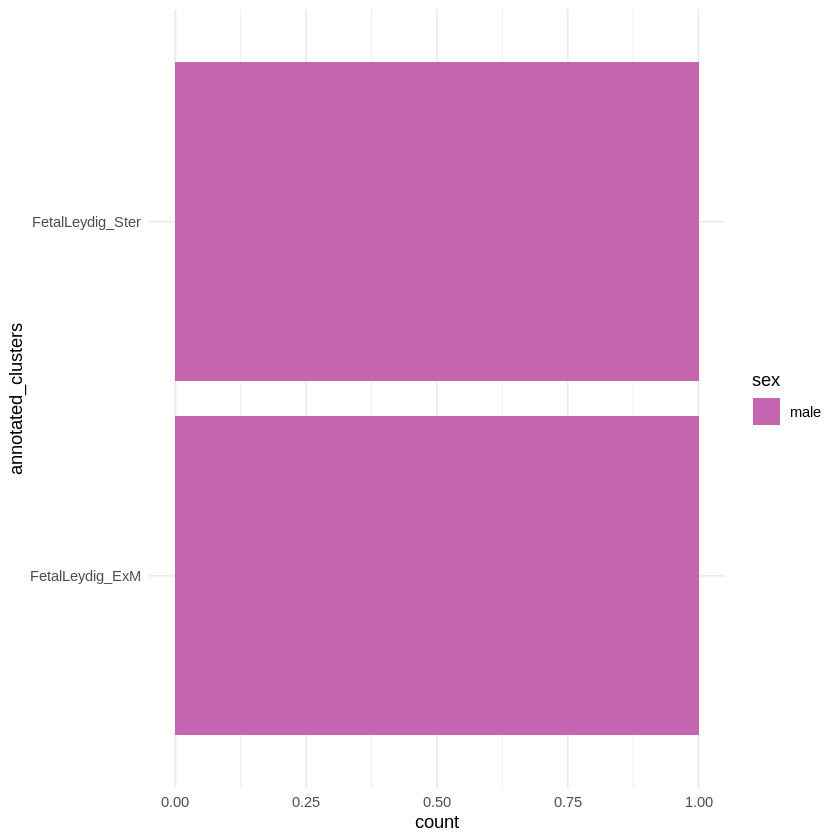

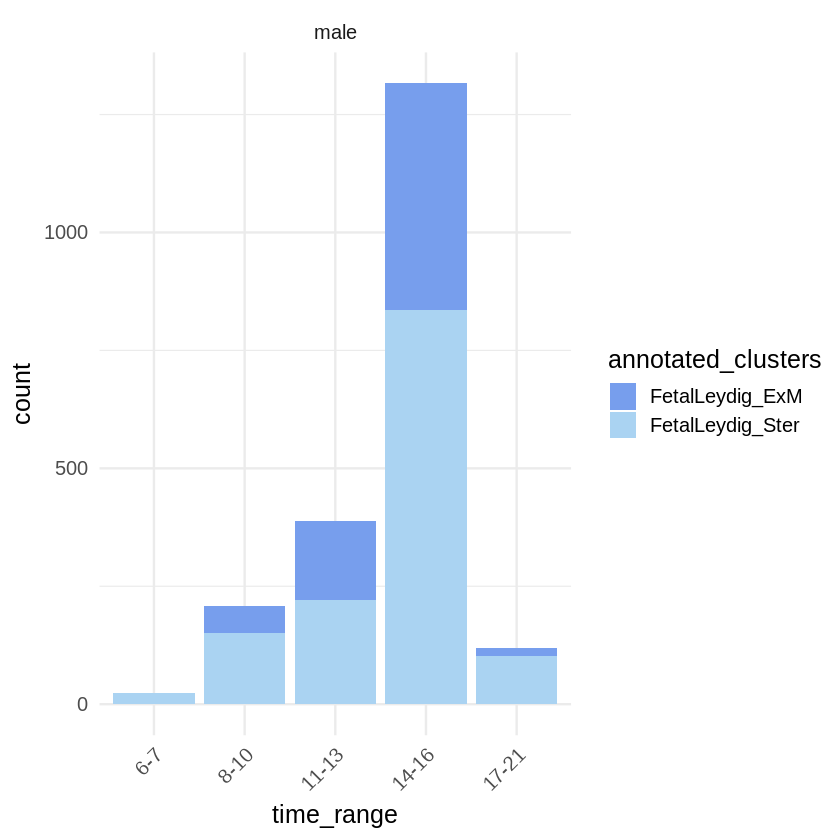

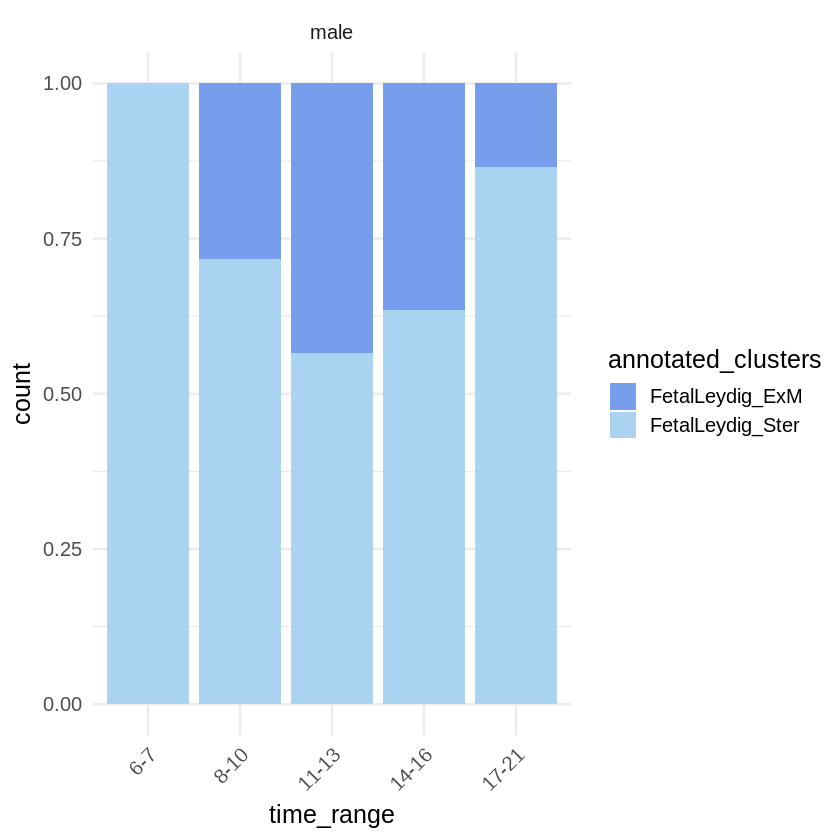

In [15]:
DimPlot(anndataO, reduction = "umap", label = F, pt.size =0.5, 
        cols = mycolors) + 
        ggtitle(paste0('Fetal-Leydig\nn = ', ncol(anndataO)))+ 
        theme(panel.border = element_rect(colour = "black", fill=NA, size=1))
ggsave(filename = paste0('figures-Leydig/0_F2_umap_annotated.pdf'), dpi = 300, width = 6.5, height = 5)


DimPlot(anndataO, reduction = "umap", group.by = 'seurat_clusters', label = T, cols = colors, pt.size =0.5) + ggtitle('louvain')+ 
        theme(panel.border = element_rect(colour = "black", fill=NA, size=1))
ggsave(filename = paste0('figures-Leydig/0_FS2_umap_louvain.pdf'), dpi = 300, width = 6.5, height = 5)

DimPlot(anndataO, reduction = "umap", group.by = 'clusters', label = T, cols = colors, pt.size =0.5) + ggtitle('lineage')+ 
        theme(panel.border = element_rect(colour = "black", fill=NA, size=1))
ggsave(filename = paste0('figures-Leydig/0_FS2_umap_lineage.pdf'), dpi = 300, width = 6.5, height = 5)


DimPlot(anndataO, reduction = "umap", group.by = 'individual', label = F, cols = colors, pt.size =0.5) + ggtitle('individual')+ 
        theme(panel.border = element_rect(colour = "black", fill=NA, size=1))
ggsave(filename = paste0('figures-Leydig/0_FS2_umap_individual.pdf'), dpi = 300, width = 6.5, height = 5)


DimPlot(anndataO, reduction = "umap", group.by = 'Phase', pt.size =0.5) + ggtitle('cell cycle phase')+ 
        theme(panel.border = element_rect(colour = "black", fill=NA, size=1))
ggsave(filename = paste0('figures-Leydig/0_FS2_umap_cellcyclephase.pdf'), dpi = 300, width = 6.5, height = 5)


DimPlot(anndataO, reduction = "umap", group.by = 'sex', pt.size =0.5, cols = c('#f5829f', '#71a2c7')) + ggtitle('sex')+ 
        theme(panel.border = element_rect(colour = "black", fill=NA, size=1))
ggsave(filename = paste0('figures-Leydig/0_FS2_umap_sex.pdf'), dpi = 300, width = 6.5, height = 5)

ggplot(anndataO@meta.data, aes(x=annotated_clusters, fill = sex) ) + 
    geom_bar(position = 'fill') + coord_flip() + scale_fill_manual(values = luz_colors) +
    theme_minimal()
ggsave(filename = paste0('figures-Leydig/0_FS2_barplot_sex.pdf'), dpi = 300, width = 5.5, height = 5)


anndataO@meta.data$time_range = '6-7'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >= 8 ] = '8-10'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >= 11 ] = '11-13'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >= 14 ] = '14-16'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >17 ] = '17-21'
anndataO@meta.data$time_range = factor(anndataO@meta.data$time_range, levels = c('6-7', '8-10', '11-13', '14-16', '17-21') )
ggplot(anndataO@meta.data, aes(x=time_range, fill = annotated_clusters) ) + 
    scale_fill_manual(values = mycolors) +
    facet_wrap(~sex)+
#     geom_bar(position = 'fill')+
    geom_bar()+
    theme_minimal(15) + theme(axis.text.x = element_text(angle = 45, hjust=1))
ggsave(filename = paste0('figures-Leydig/0_FS2_barplot_PCWs_sex.pdf'), dpi = 300, width = 5.5, height = 4.5)

ggplot(anndataO@meta.data, aes(x=time_range, fill = annotated_clusters) ) + 
    scale_fill_manual(values = mycolors) +
    facet_wrap(~sex)+
    geom_bar(position = 'fill')+
    theme_minimal(15) + theme(axis.text.x = element_text(angle = 45, hjust=1))
ggsave(filename = paste0('figures-Leydig/0_FS2_barplot_PCWs_sexII.pdf'), dpi = 300, width = 5.5, height = 4.5)

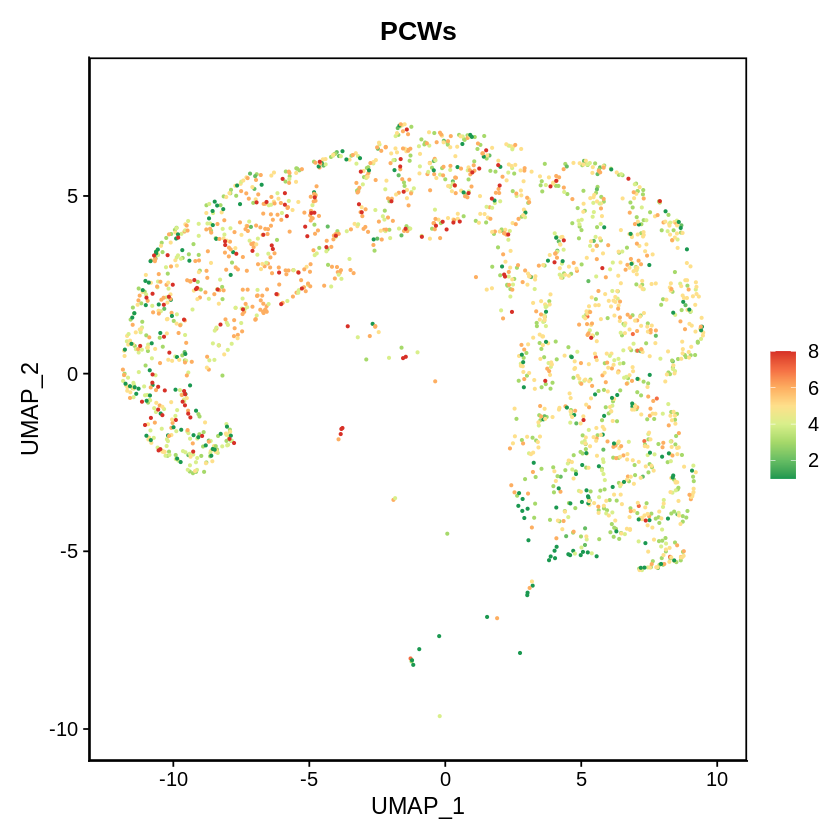

In [79]:
anndataO$PCW = as.numeric(anndataO$PCW)
FeaturePlot(anndataO, reduction = "umap", features = 'PCW', pt.size =0.5, cols = rev(brewer.pal(n = 8, name = 'RdYlGn')) ) + 
    ggtitle('PCWs') + 
   theme(panel.border = element_rect(colour = "black", fill=NA, size=1))
ggsave(filename = paste0('figures-Leydig/0_FS2_umap_PCWs.pdf'), dpi = 300, width = 5.5, height = 5)

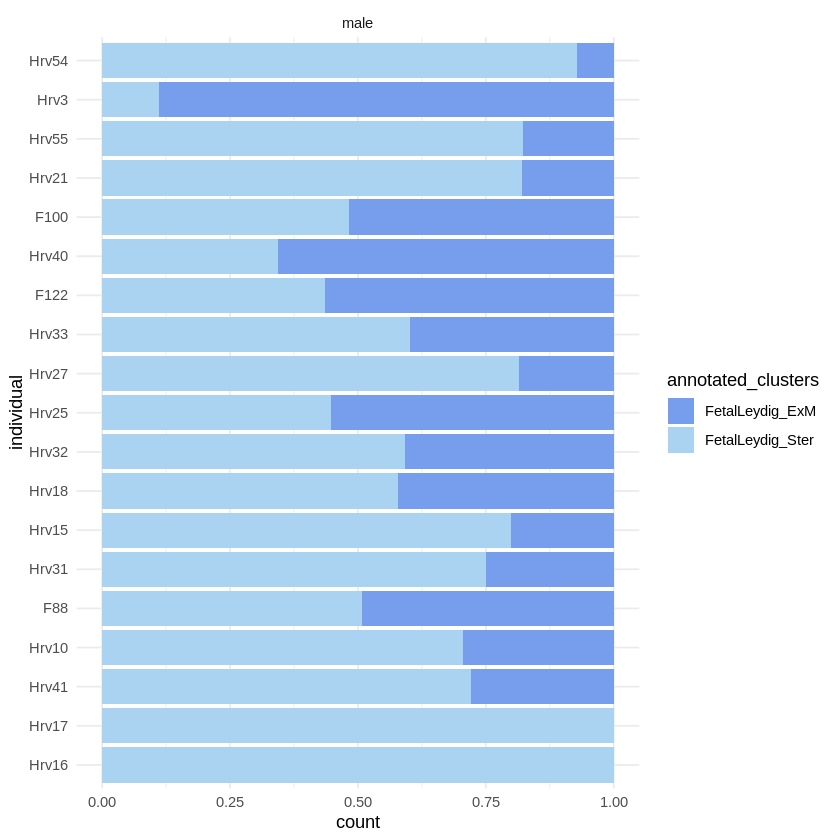

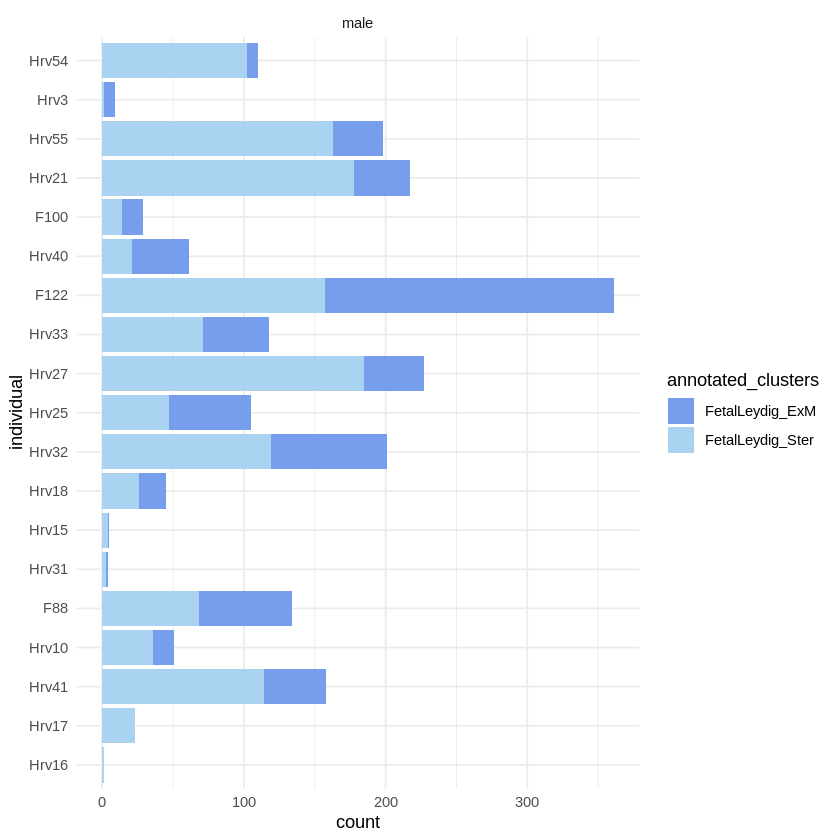

In [77]:
anndataO@meta.data$individual = factor(anndataO@meta.data$individual, levels = unique(anndataO@meta.data$individual[ order(anndataO@meta.data$PCW) ]))
ggplot(anndataO@meta.data, aes(x=individual, fill = annotated_clusters) ) + 
    geom_bar(position = 'fill') + coord_flip() + scale_fill_manual(values = mycolors) +
    facet_wrap(~sex)+
    theme_minimal()
ggsave(filename = paste0('figures-Leydig/0_FS2_barplot_individuals_sex.pdf'), dpi = 300, width = 7, height = 5.5)

ggplot(anndataO@meta.data, aes(x=individual, fill = annotated_clusters) ) + 
    geom_bar() + coord_flip() + scale_fill_manual(values = mycolors) +
    facet_wrap(~sex)+
    theme_minimal()
ggsave(filename = paste0('figures-Leydig/0_FS2_barplot_individuals_sexII.pdf'), dpi = 300, width = 7, height = 5.5)

# Known markers

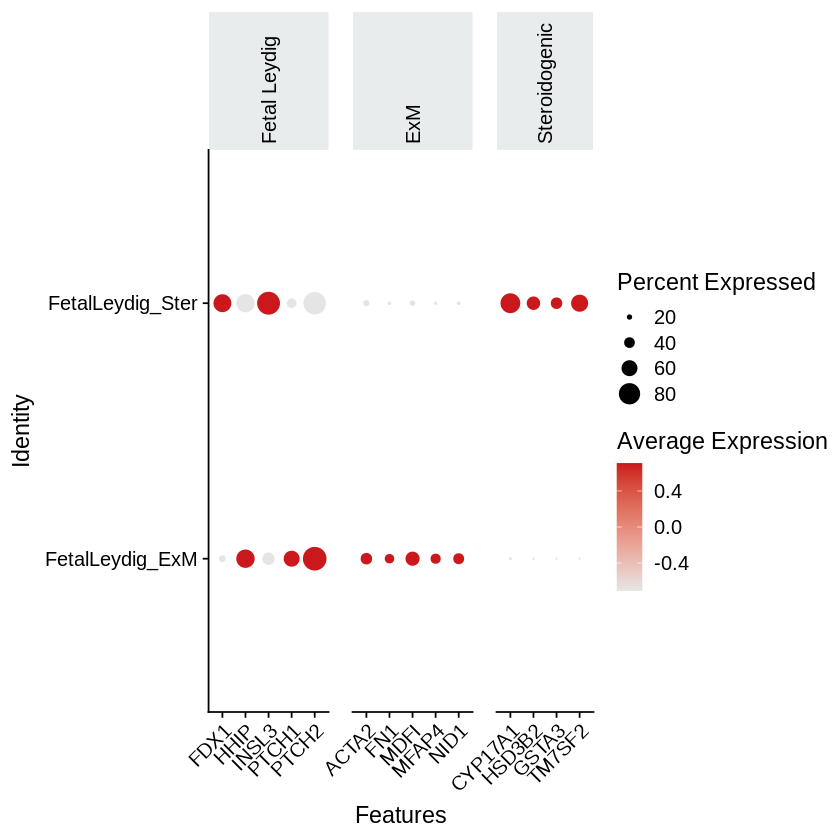

In [84]:
DotPlot(anndataO, features = markers, cols = col_dot) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced"))
ggsave(filename = paste0('figures-Leydig/0_F2_dotplot_markers.pdf'), dpi = 75, height = 3.5, width = 7.2)

# Exclude cycling cells and sex-missasigned as these are confounders for DEGs

In [59]:
non_confident_females = colnames(anndataO)[ which(Idents(anndataO) %in% c( 'Sertoli_WFDC2', 'Sertoli', 'Sertoli_low',  'FetalLeydig-like')  & anndataO$sex == 'female' ) ]
non_confident_males = colnames(anndataO)[ which(Idents(anndataO) %in% c( 'preGC_I_OSR1', 'ovarianSurf', 'preGC_II', 'preGC_II_hypoxia', 'preGC_III', 'preGC_III_Notch')  & anndataO$sex == 'male' ) ] 
anndataO = subset(anndataO, cells = colnames(anndataO)[ ! colnames(anndataO) %in%  c(non_confident_females, non_confident_males) ] )

# GWAS PCOS markers

Warning message in FetchData(object = object, vars = features, cells = cells):
“The following requested variables were not found (10 out of 30 shown): AC009041.1, KAZN-AS1, KAZN, IQCA1, ACKR3, AC091893.2, CDH10, AL358944.1, FIGN, RNU6-627P, FSHR, AC009975.1, AC013652.1, LINC02694, IRF1-AS1, AC116366.3, AC078923.1, KRR1”


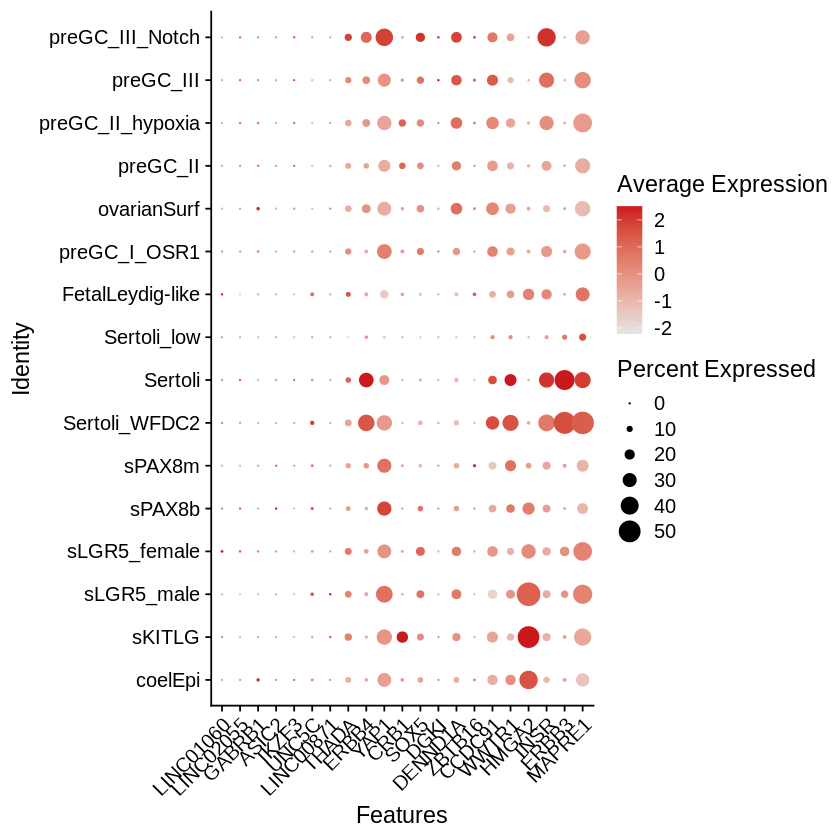

In [21]:
GWAS = read.csv('/nfs/team292/vl6/GWAS_gonads/GWAS_PCOS.csv', stringsAsFactors = F)
DotPlot(anndataO, features = unique(GWAS$Mapped.gene), cols = col_dot) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced"))
ggsave(filename = paste0('figures-Leydig/0_F2_dotplot_GWAS.pdf'), dpi = 75, height = 5, width = 14)

### sPAX8 interactions

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



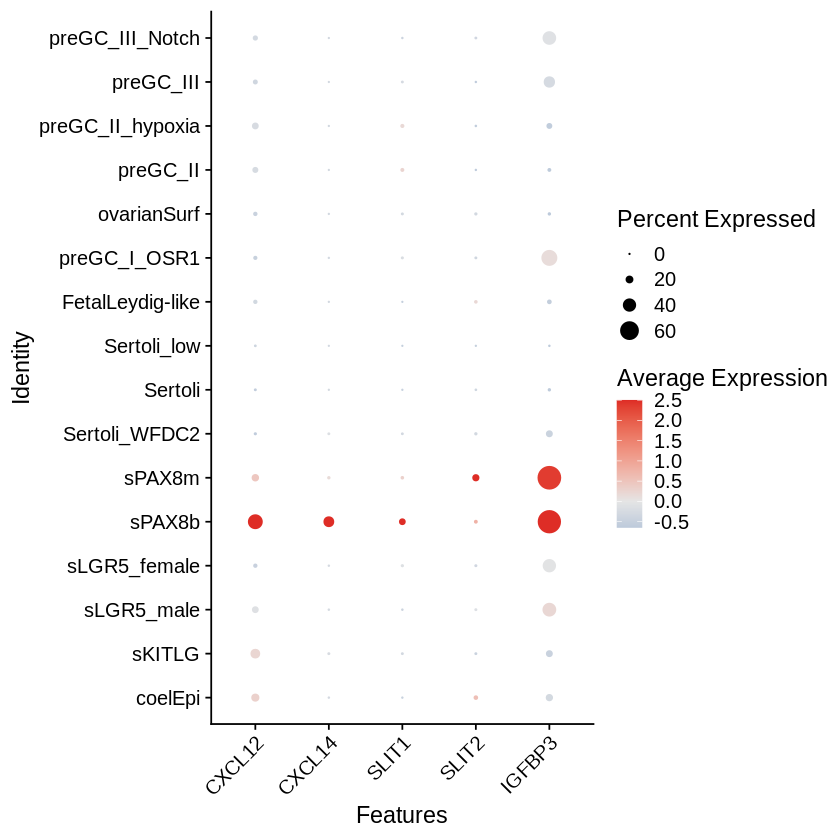

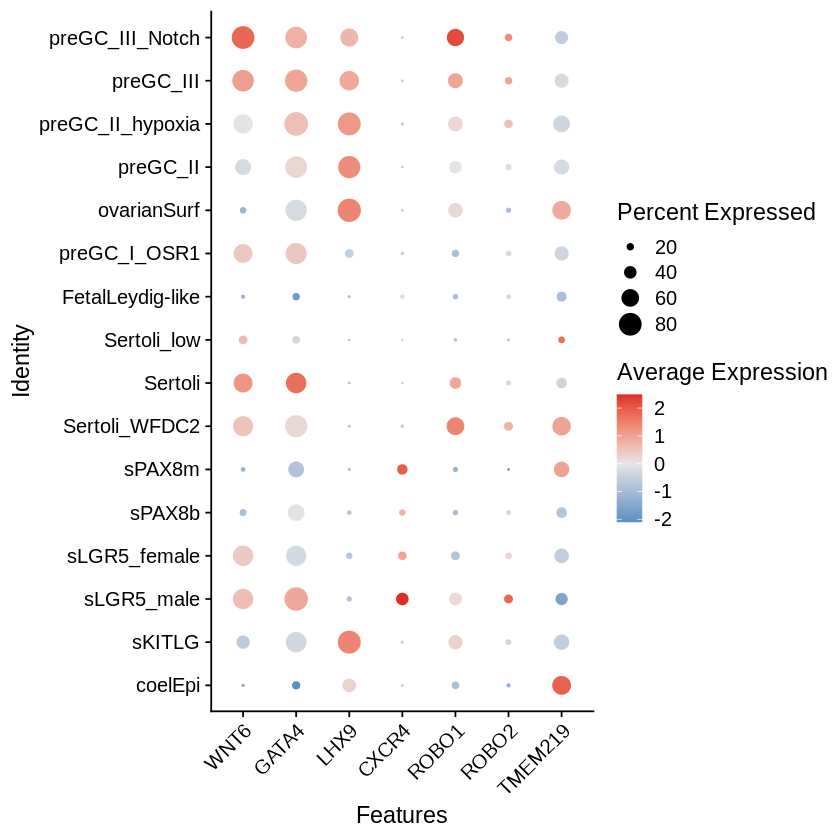

In [22]:
DotPlot(anndataO, features = c('CXCL12', 'CXCL14', 'SLIT1', 'SLIT2', 'IGFBP3')) + RotatedAxis() +  
         scale_color_gradient2(low = brewer.pal(n = 5, name = 'Blues')[4], 
                              high = brewer.pal(n = 5, name = 'Reds')[4], 
                              mid = 'grey90')
ggsave(filename = paste0('figures-Leydig/0_F2_dotplot_sPAX8_ligands.pdf'), dpi = 75, height = 3.5, width = 5)

DotPlot(anndataO, features = c('WNT6', 'GATA4', 'LHX9', 'CXCR4', 'ROBO1', 'ROBO2',  'TMEM219')) + RotatedAxis() + 
         scale_color_gradient2(low = brewer.pal(n = 5, name = 'Blues')[4], 
                              high = brewer.pal(n = 5, name = 'Reds')[4], 
                              mid = 'grey90')
ggsave(filename = paste0('figures-Leydig/0_F2_dotplot_sPAX8_receptors.pdf'), dpi = 75, height = 3.5, width = 5)

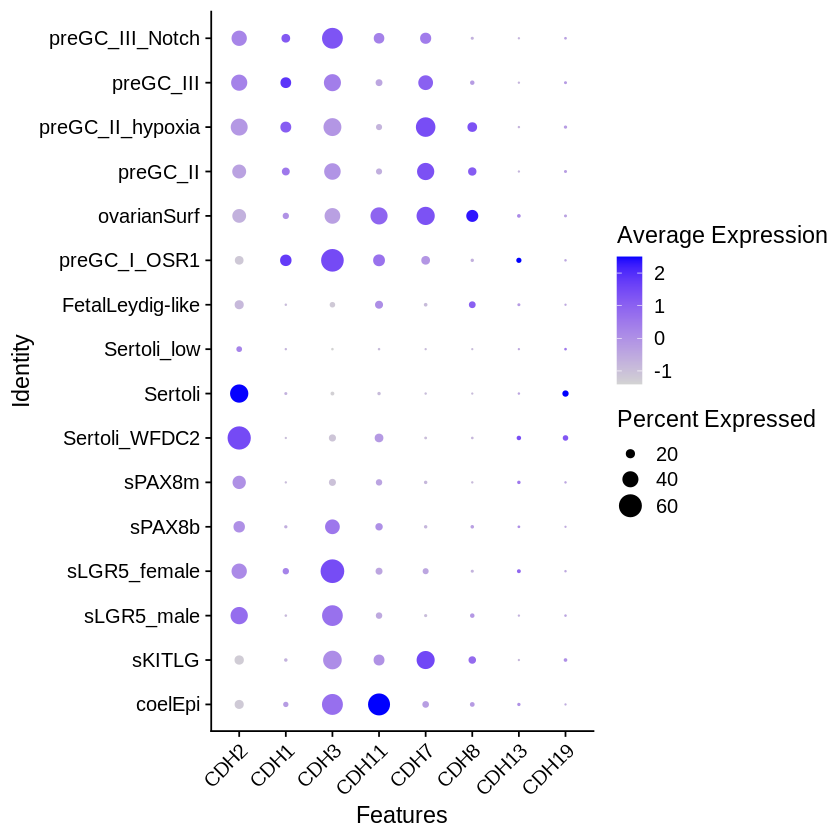

In [23]:
DotPlot(anndataO, features = c('CDH2',
                               'CDH1',  'CDH3', 'CDH11',   'CDH7', 'CDH8',  'CDH13',
                                'CDH19')) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced"))

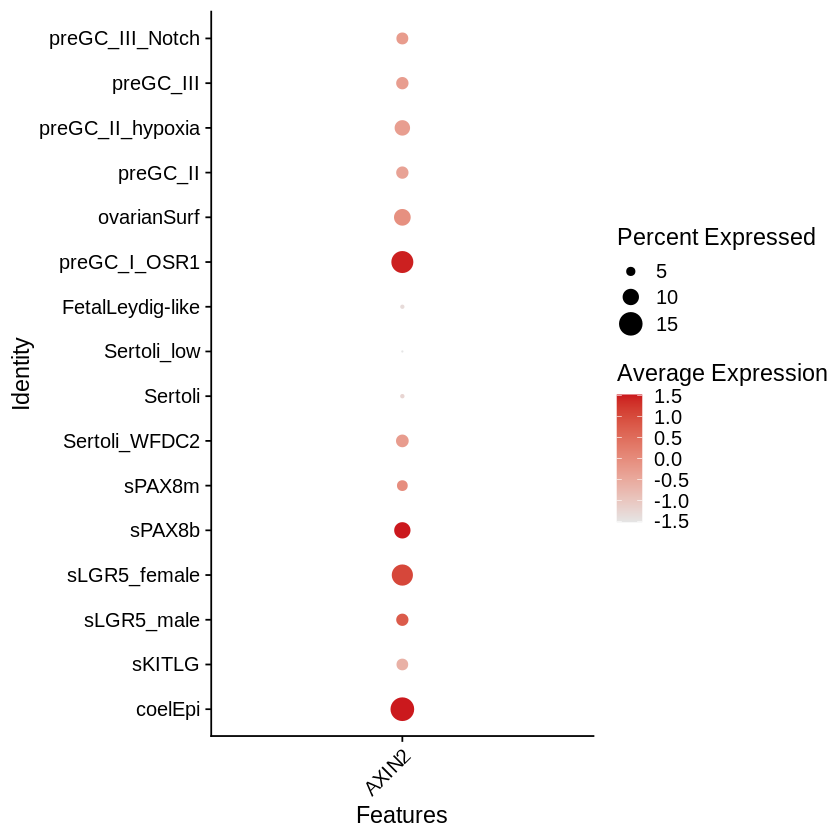

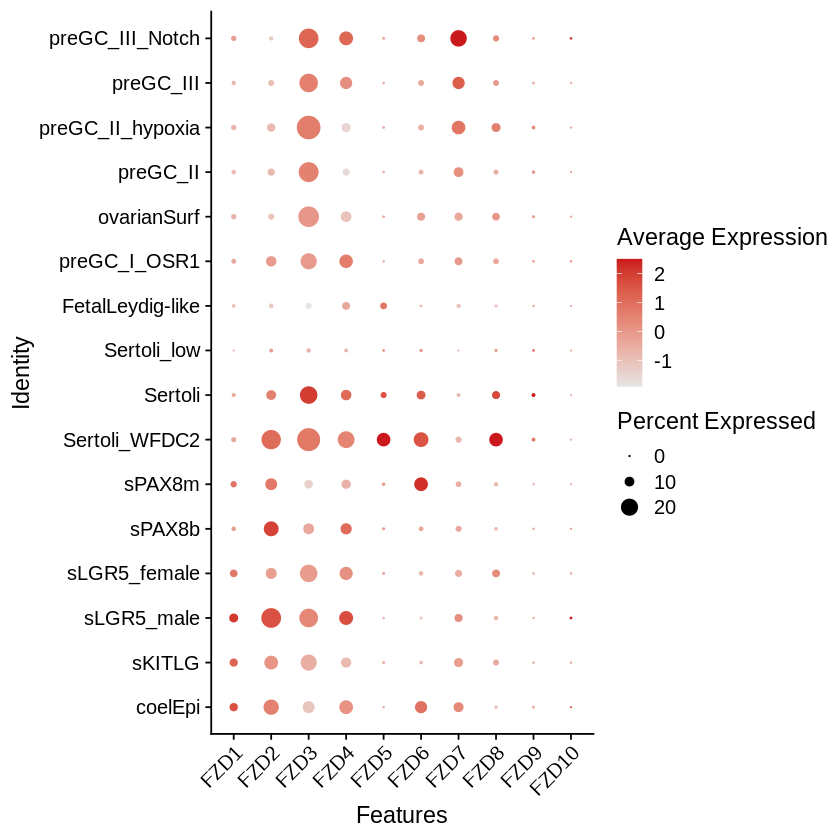

In [24]:
DotPlot(anndataO, features = c('AXIN2'), group.by = 'sex_annot', cols = col_dot) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0), 
          strip.background = element_rect(fill="#e8eced"))

DotPlot(anndataO, features = c('FZD1',  'FZD2', 'FZD3',  'FZD4', 'FZD5',  'FZD6', 'FZD7',  'FZD8', 'FZD9', 'FZD10'), cols = col_dot) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0), 
          strip.background = element_rect(fill="#e8eced"))


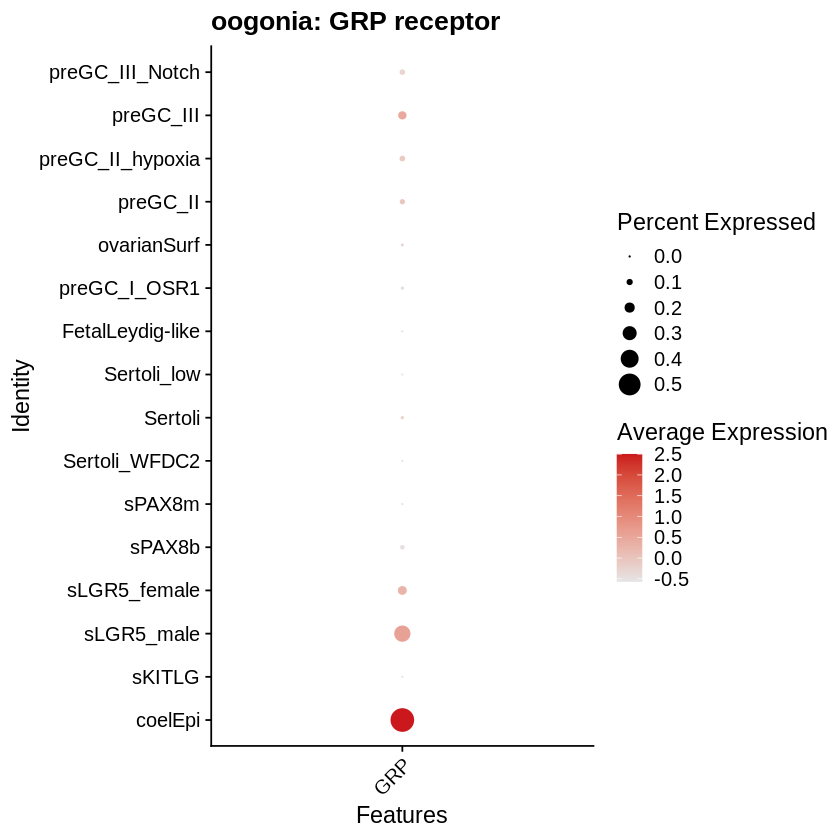

In [25]:
DotPlot(anndataO, features = c('GRP'), cols = col_dot) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0), 
          strip.background = element_rect(fill="#e8eced")) + 
    ggtitle('oogonia: GRP receptor')

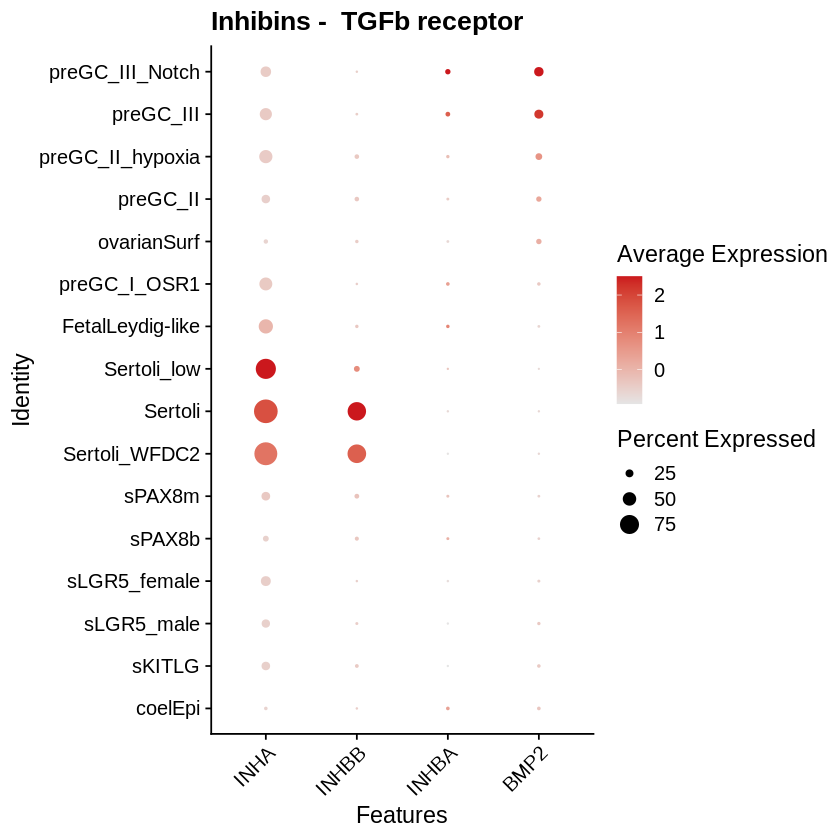

In [26]:
DotPlot(anndataO, features = c('INHA', 'INHBB', 'INHBA', 'BMP2'), cols = col_dot) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0), 
          strip.background = element_rect(fill="#e8eced")) + 
    ggtitle('Inhibins -  TGFb receptor')# 'INHA', 'INHBB', 'SMAD2' in males
ggsave(filename = paste0('figures-supporting/0_Fint_dotplot_TGFb.pdf'), dpi = 75, height = 4, width = 5)

### Locate Sertoli/Leydig paracrine markers

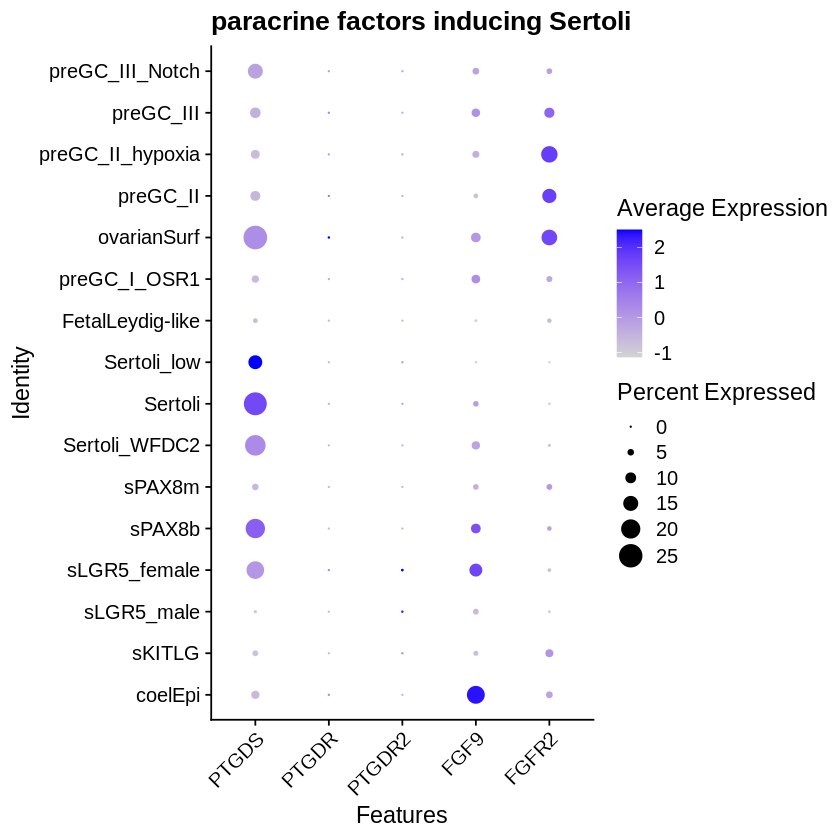

In [27]:
DotPlot(anndataO, features = c('PTGDS', 'PTGDR', 'PTGDR2','FGF9', 'FGFR2'), group.by = 'sex_annot') + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced")) + ggtitle('paracrine factors inducing Sertoli')

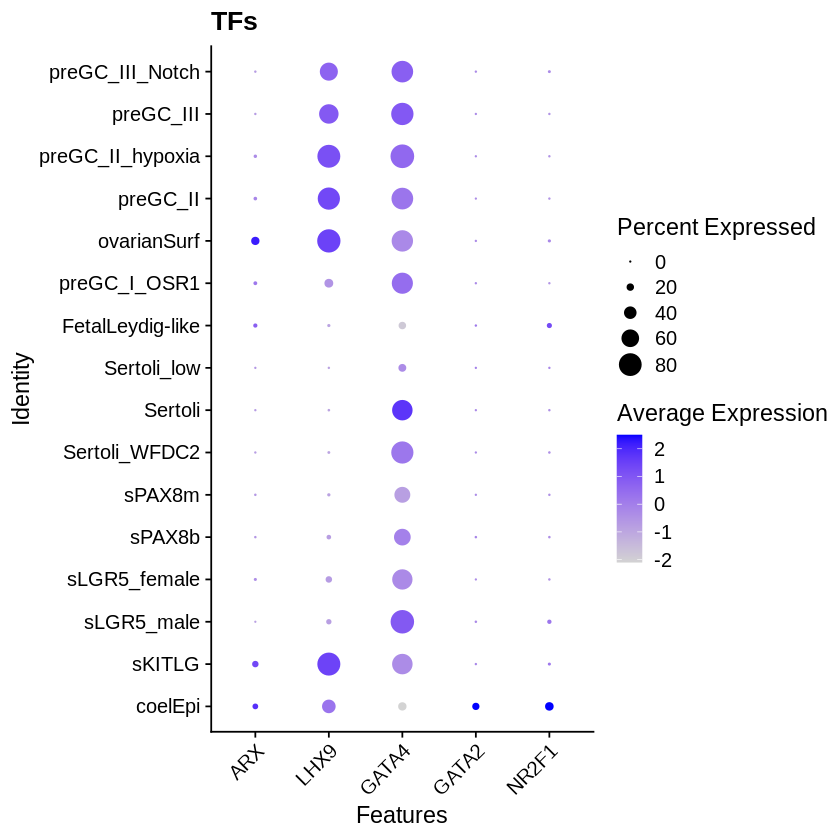

In [28]:
DotPlot(anndataO, features = c('ARX', 'LHX9', 'GATA4', 'GATA2',  'NR2F1')) + RotatedAxis() + ggtitle('TFs')

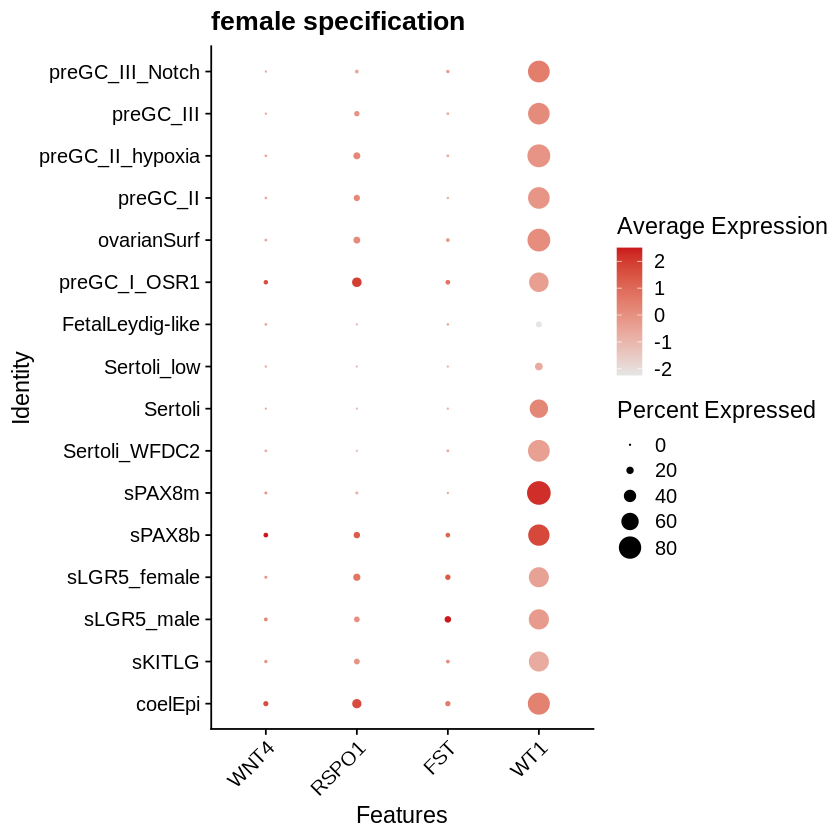

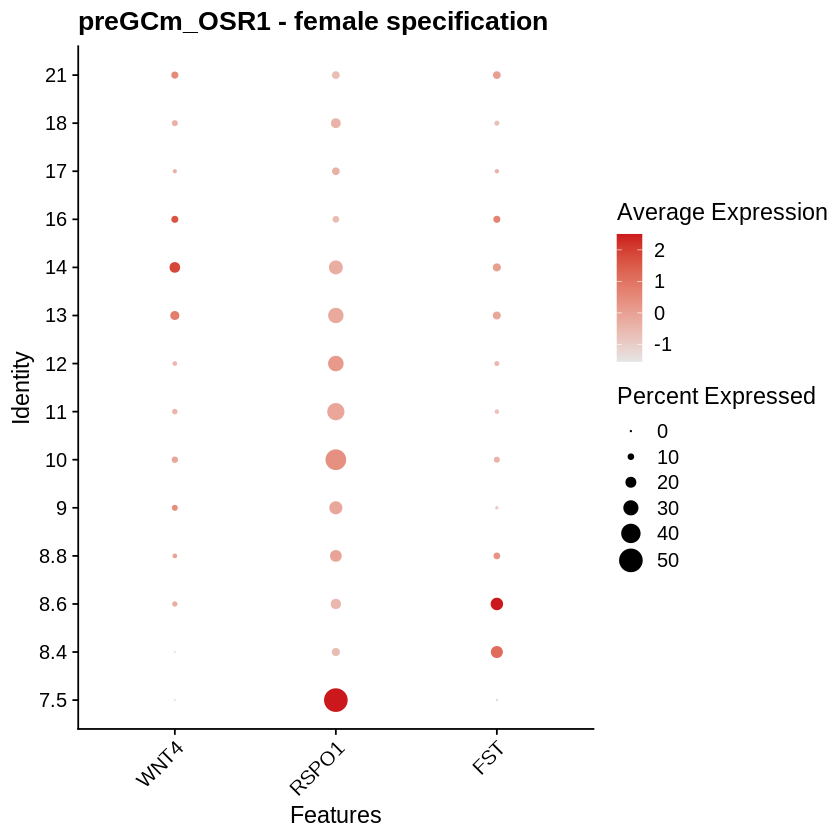

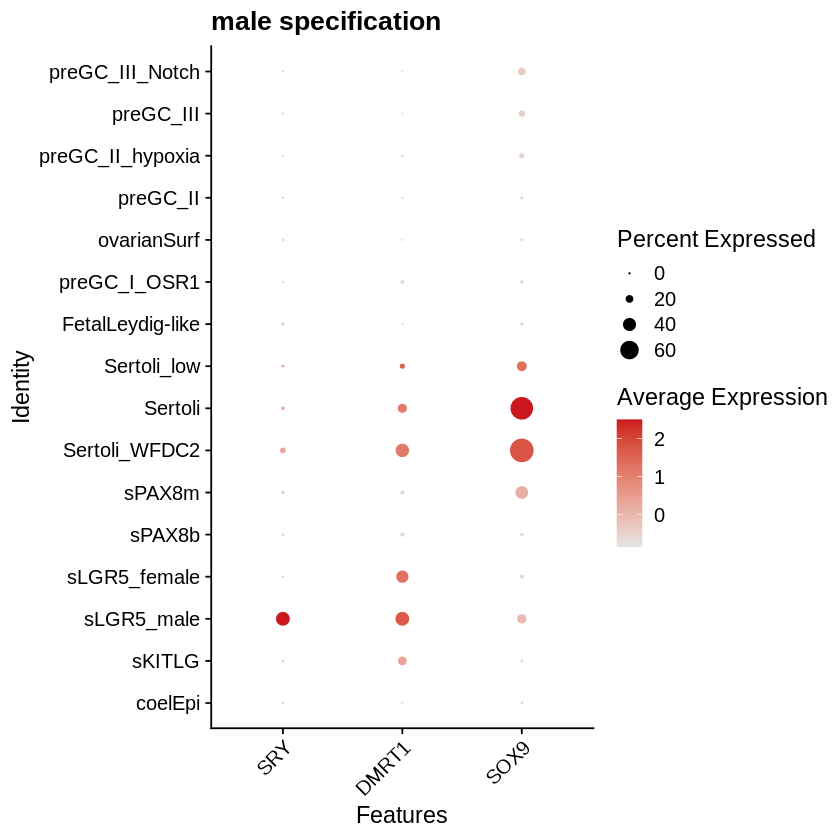

In [29]:
DotPlot(anndataO, features = c('WNT4', 'RSPO1', 'FST', 'WT1'), group.by = 'sex_annot', cols = col_dot) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced")) + ggtitle('female specification')
ggsave(filename = paste0('figures-Leydig/0_FS2_dotplot_markers_femaleSpecification.pdf'), dpi = 75, height = 5, width = 6)

preGC_OSR1 = subset(anndataO, cells = colnames(anndataO)[ anndataO$annotated_clusters %in% c('preGC_I_OSR1') & anndataO$sex == 'female' ] )
DotPlot(preGC_OSR1, features = c('WNT4', 'RSPO1', 'FST'), group.by = 'PCW', cols = col_dot) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced")) + ggtitle('preGCm_OSR1 - female specification')
ggsave(filename = paste0('figures-Leydig/0_FS2_dotplot_markers_femaleSpecification_preGCm_OSR1.pdf'), dpi = 75, height = 5, width = 6)

DotPlot(anndataO, features = c('SRY', 'DMRT1', 'SOX9'), group.by = 'sex_annot', cols = col_dot) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced")) + ggtitle('male specification')
ggsave(filename = paste0('figures-Leydig/0_FS2_dotplot_markers_maleSpecification.pdf'), dpi = 75, height = 5, width = 6)

# PLOT cellphoneDB genes for pre-Granulosa

In [30]:
PGCs_partners = c('BMP4', 'PDGFRA', 'PDGFRB',  'SFRP1', 'SFRP2', 'LRP6', 'FZD2', 'FZD4', 'FZD6',
                     'ADRA2A','ADRB3', 'EPHA4', 'CXCR4', 'KITLG','NRG1')

STRA8_interactors = c('NOTCH2','ACVR2B', 'BMPR1A','BMPR1B','BMP6', 'BMP2' ,
                     'STRA6', 'CYP19A1',  'HSD17B1', 'WNT6')

follicle_interactors = c('NR1H4','ESR1', 'ESR2', 'BMPR2', 'BMPR1A', 'BMPR1B', 'ACVR2B', 'TGFBR1', 
                         'NOTCH2', 'NOTCH3', 'CD46', 'HRH1', 'ERBB4', 'NTN1','RELN','EFNB1')

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



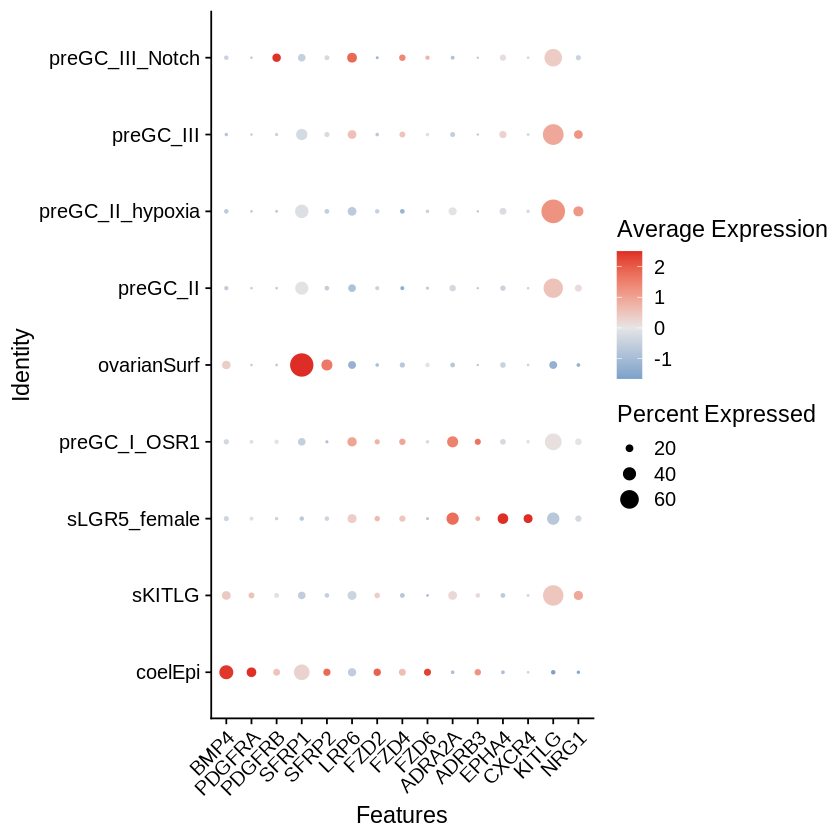

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



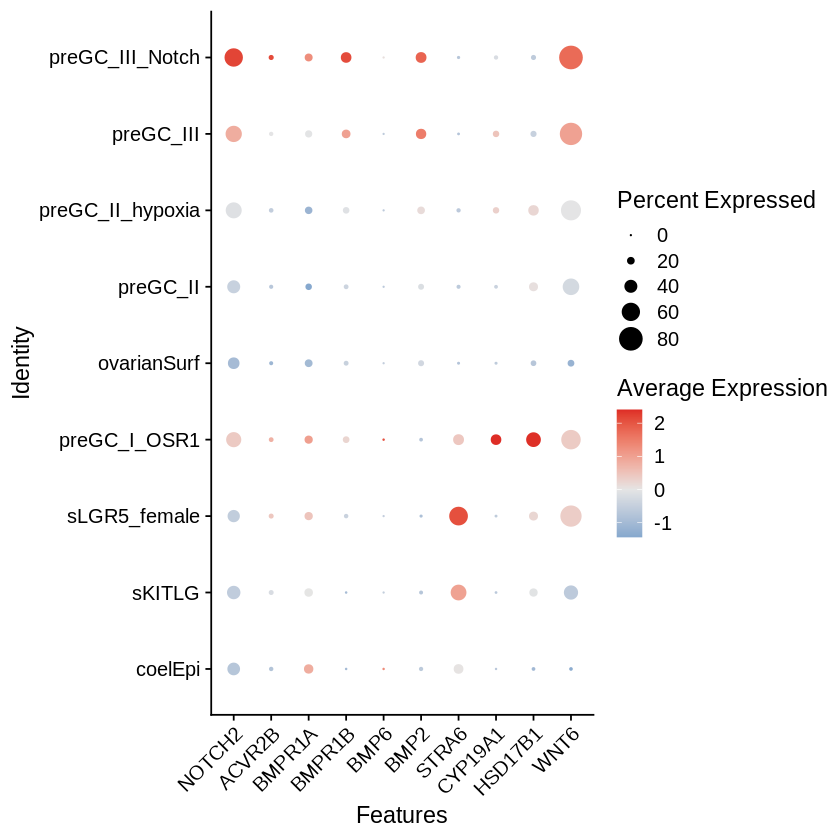

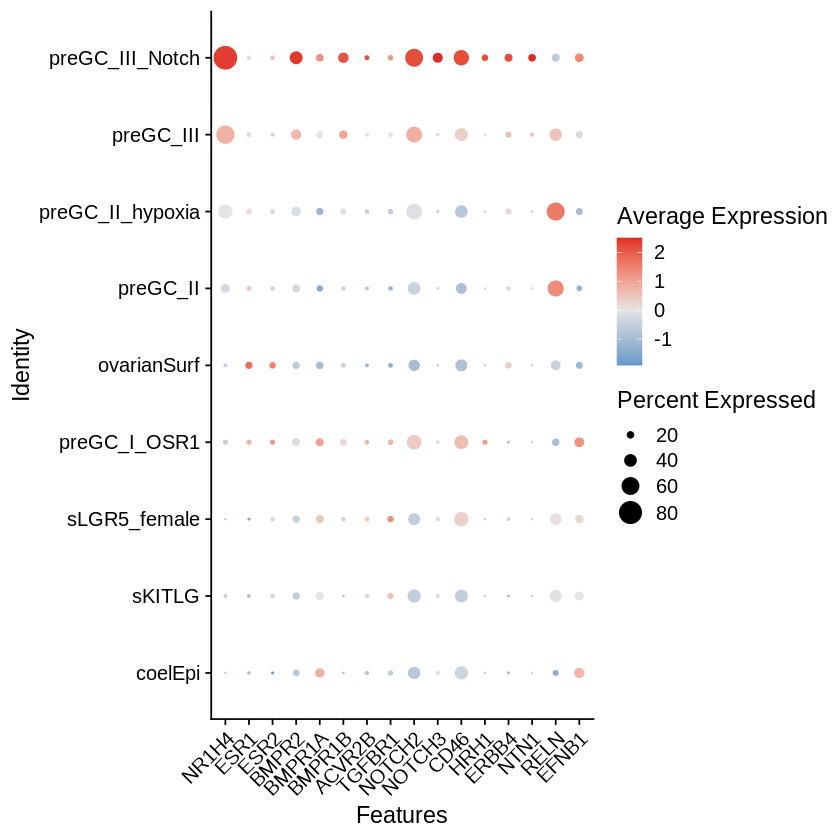

In [38]:
# aFemale = subset(anndataO, cells = colnames(anndataO)[ ! anndataO$major_pop %in% c('Sertoli', 'FetalLeydig-like', 'sPAX8') & anndataO$sex == 'female'])

DotPlot(aFemale, features = PGCs_partners) + RotatedAxis() +  
         scale_color_gradient2(low = brewer.pal(n = 5, name = 'Blues')[4], 
                              high = brewer.pal(n = 5, name = 'Reds')[4], 
                              mid = 'grey90')
ggsave(filename = paste0('figures-Leydig/0_F2_dotplot_cellphoneDB_PGCs.pdf'), dpi = 75, height = 3.5, width = 8)

DotPlot(aFemale, features = STRA8_interactors) + RotatedAxis() +  
         scale_color_gradient2(low = brewer.pal(n = 5, name = 'Blues')[4], 
                              high = brewer.pal(n = 5, name = 'Reds')[4], 
                              mid = 'grey90')
ggsave(filename = paste0('figures-Leydig/0_F2_dotplot_cellphoneDB_STRA8.pdf'), dpi = 75, height = 3.5, width = 8)


DotPlot(aFemale, features = follicle_interactors) + RotatedAxis() +  
         scale_color_gradient2(low = brewer.pal(n = 5, name = 'Blues')[4], 
                              high = brewer.pal(n = 5, name = 'Reds')[4], 
                              mid = 'grey90')
ggsave(filename = paste0('figures-Leydig/0_F2_dotplot_cellphoneDB_follicle.pdf'), dpi = 75, height = 3.5, width = 8)

# Unbiased markers

## TF-IDF approach

### High resolution populations

In [ ]:
allDown = downsample_data(anndataO, N = 1000, var = 'sex_annot')

df_tfIDF = quickMarkers(toc = allDown@assays$RNA@counts, clusters = allDown$sex_annot, N = 500)
write.csv(df_tfIDF, file = 'figures-Leydig/0_FS2_table_TFIDF_annotated.csv', quote = F, row.names = F)

df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = levels(anndataO$sex_annot) )
DEGs_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF)) + RotatedAxis()
ggsave(filename = paste0('figures-Leydig/0_FS2_dotplot_TFIDF_annotated.pdf'), dpi = 75, height = 6, width = 45)

In [ ]:
# plot sPAX8 markers
sPAX8_genes = subset(df_tfIDF, cluster %in% c('sPAX8b', 'sPAX8m') & qval < 0.001 )$gene[1:20]
DotPlot(anndataO, features = sPAX8_genes, 
        cols = col_dot ) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced")) + ggtitle('PAX8 markers')
ggsave(filename = paste0('figures-Leydig/0_F2_dotplot_sPAX8_markers.pdf'), dpi = 75, height = 4, width = 8)

##### any sPAX8 sufrace markers?

In [ ]:
sPAX8_genes = subset(df_tfIDF, cluster %in% c('sPAX8b', 'sPAX8m') & qval < 0.001 )$gene

mem_prot =read.delim('utils/membrane_proteins.tab', stringsAsFactors = F)
mem_prot$gene = strsplit(mem_prot$Gene.names, ' ') %>% sapply(., head, 1) %>% as.character(.)

DotPlot(anndataO, features = intersect(sPAX8_genes, mem_prot$gene), cols = col_dot) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced"))
ggsave(filename = paste0('figures-Leydig/0_FS2_dotplot_sPAX8_candidate_surfMarkers.pdf'), dpi = 75, height = 5, width = 35)

##### any sPAX8 DEG is angiogenic?

In [ ]:
sPAX8_genes = subset(df_tfIDF, cluster %in% c('sPAX8b', 'sPAX8m') & qval < 0.001 )$gene

angio_prot =read.delim('utils/angiogenesis_I.txt', stringsAsFactors = F, header = F)[,1]

DotPlot(anndataO, features = intersect(sPAX8_genes, angio_prot), cols = col_dot) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced"))
ggsave(filename = paste0('figures-Leydig/0_FS2_dotplot_sPAX8_candidate_angioProts.pdf'), dpi = 75, height = 5, width = 35)

### All major populations

In [ ]:
majorDown = downsample_data(allDown, var = 'major_pop', N = 1000)

df_tfIDF = quickMarkers(toc = majorDown@assays$RNA@counts, clusters = majorDown$lineages, N = 10000)

write.csv(df_tfIDF, file = 'figures-Leydig/0_FS2_table_TFIDF_majorpop.csv', quote = F, row.names = F)
DEGs_tfIDF = subset(df_tfIDF, qval <= 0.1) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 40L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF), group.by = 'major_pop') + RotatedAxis()
ggsave(filename = paste0('figures-Leydig/0_FS2_dotplot_TFIDF_majorpop.pdf'), dpi = 75, height = 5, width = 25)
rm(majorDown)

### Granulosa versus Sertoli

In [ ]:
SerGcDown = subset(allDown, cells = colnames(allDown)[ allDown$major_pop %in% c('Sertoli','preGC')] )
df_tfIDF = quickMarkers(toc = SerGcDown@assays$RNA@counts, clusters = SerGcDown$major_pop, N = 100000)
write.csv(df_tfIDF, file = 'figures-Leydig/0_FS2_table_TFIDF_Ser_vs_GC.csv', quote = F, row.names = F)

DEGs_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 25L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF), group.by = 'annotated_clusters') + RotatedAxis()
ggsave(filename = paste0('figures-Leydig/0_FS2_dotplot_TFIDF_Ser_vs_GC.pdf'), dpi = 75, height = 5, width = 20)
rm(SerGcDown)

## Within Granulosa

In [ ]:
GcDown = subset(allDown, cells = colnames(allDown)[ allDown$major_pop %in% c('preGC') & allDown$sex == 'female'] )
df_tfIDF = quickMarkers(toc = GcDown@assays$RNA@counts, clusters = GcDown$annotated_clusters, N = 100000)
write.csv(df_tfIDF, file = 'figures-Leydig/0_FS2_table_TFIDF_Granulosa.csv', quote = F, row.names = F)

DEGs_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 25L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF), group.by = 'annotated_clusters') + RotatedAxis()
ggsave(filename = paste0('figures-Leydig/0_FS2_dotplot_TFIDF_Granulosa.pdf'), dpi = 75, height = 5, width = 25)
rm(GcDown)

## Sexually dimorphic genes in sex-shared populations

In [ ]:
aLGR5 = subset(allDown, cells = colnames(allDown)[ allDown@meta.data$annotated_clusters %in% c('sLGR5') ]) 
df_tfIDF = quickMarkers(toc = aLGR5@assays$RNA@counts, clusters = aLGR5$sex_annot, N = 20)
DEGs_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 25L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF)) + RotatedAxis()
ggsave(filename = paste0('figures-Leydig/0_FS2_dotplot_sexTFIDFinLGR5.pdf'), dpi = 75, height = 5, width = 15)
write.csv(df_tfIDF, file = 'figures-Leydig/0_FS2_table_sexTFIDFinLGR5.csv', quote = F, row.names = F)
rm(aLGR5)

sKITLG = subset(allDown, cells = colnames(allDown)[ allDown@meta.data$annotated_clusters %in% c('sKITLG') ]) 
df_tfIDF = quickMarkers(toc = sKITLG@assays$RNA@counts, clusters = sKITLG$sex_annot, N = 20)
DEGs_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 25L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF)) + RotatedAxis()
ggsave(filename = paste0('figures-Leydig/0_FS2_dotplot_sexTFIDFinPAX8.pdf'), dpi = 75, height = 5, width = 15)
write.csv(df_tfIDF, file = 'figures-Leydig/0_FS2_table_sexTFIDFinPAX8.csv', quote = F, row.names = F)
rm(sKITLG)

## Within male

In [ ]:
aMale = subset(anndataO, cells = colnames(anndataO)[ ! anndataO$major_pop %in% c('preGC') & anndataO$sex == 'male'])
maleDown = downsample_data(aMale, var = 'sex_annot', N = 500)

df_tfIDF = quickMarkers(toc = maleDown@assays$RNA@counts, clusters = maleDown$annotated_clusters, N = 100000)
write.csv(df_tfIDF, file = 'figures-Leydig/0_FS2_table_TFIDF_male.csv', quote = F, row.names = F)

DEGs_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 25L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF), group.by = 'annotated_clusters') + RotatedAxis()
ggsave(filename = paste0('figures-Leydig/0_FS2_dotplot_TFIDF_male.pdf'), dpi = 75, height = 5, width = 25)
rm(aMale)
rm(maleDown)

## Within female

In [ ]:
aFemale = subset(anndataO, cells = colnames(anndataO)[ ! anndataO$major_pop %in% c('Sertoli') & anndataO$sex == 'female'])
femaleDown = downsample_data(aFemale, var = 'sex_annot', N = 500)

df_tfIDF = quickMarkers(toc = femaleDown@assays$RNA@counts, clusters = femaleDown$annotated_clusters, N = 100000)
write.csv(df_tfIDF, file = 'figures-Leydig/0_FS2_table_TFIDF_female.csv', quote = F, row.names = F)

DEGs_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 25L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF), group.by = 'annotated_clusters') + RotatedAxis()
ggsave(filename = paste0('figures-Leydig/0_FS2_dotplot_TFIDF_female.pdf'), dpi = 75, height = 5, width = 25)
rm(aFemale)
rm(femaleDown)

# DEGs

### High resolution populations

In [ ]:
allDown = downsample_data(anndataO, 'sex_annot', N = 1000)
suppressWarnings(dfDEGs <- FindAllMarkers(allDown, test.use = 'LR', verbose = T, only.pos = F, random.seed = 1, logfc.threshold = 0.05, min.pct = 0.08, return.thresh = 1))
if(is.null(dfDEGs$avg_log2FC))
    names(dfDEGs)[ names(dfDEGs) == 'avg_logFC'] = 'avg_log2FC'
write.csv(dfDEGs, file = 'figures-Leydig/0_FS2_table_DEGsAll.csv', quote = F, row.names = F)

# Plot top DEGs
DEGs = subset(dfDEGs, avg_log2FC > 0.5 & p_val_adj < 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs)) + RotatedAxis()
ggsave(filename = paste0('figures-Leydig/0_FS2_dotplot_DEGsAll.pdf'), dpi = 75, height = 7, width = 45)

### Sexually dimorphic in population in both sexes

In [ ]:
for( i in c('sLGR5', 'coelEpi', 'sKITLG') ){
    X = subset(allDown, cells = colnames(allDown)[ allDown@meta.data$annotated_clusters %in% i ]) 
    Idents(X) = X$sex_annot
    suppressWarnings(dfDEGs <- FindAllMarkers(X, test.use = 'LR', verbose = T, only.pos = T, random.seed = 1, logfc.threshold = 0.1, min.pct = 0.2, return.thresh = 1))
    if(is.null(dfDEGs$avg_log2FC))
        names(dfDEGs)[ names(dfDEGs) == 'avg_logFC'] = 'avg_log2FC'
    write.csv(dfDEGs, file = paste0('figures-Leydig/0_FS2_table_sexDEGs_',i,'.csv'), quote = F, row.names = F)

    # Plot top DEGs
    DEGs = subset(dfDEGs, avg_log2FC > 0 & p_val_adj < 0.05) %>%
      group_by(cluster) %>%
      group_map(~ head(.x, 30L)$gene) %>%
      unlist(.)
    DotPlot(allDown, features = unique(DEGs), group.by = 'sex_annot') + RotatedAxis()
    ggsave(filename = paste0('figures-Leydig/0_FS2_dotplot_sexDEGs_',i,'.pdf'), dpi = 75, height = 6, width = 20)
    }

In [ ]:
sex_genes = list()
for( i in c('sLGR5', 'coelEpi', 'sKITLG') ){
    df = read.csv(paste0('figures-Leydig/0_FS2_table_sexDEGs_',i,'.csv'), stringsAsFactors = F)
    sex_genes[[i]] = subset(df, p_val_adj < 0.01)$gene
}
sex_genes = Reduce(intersect, sex_genes)
# sex_genes =c()

for( i in c('sLGR5', 'coelEpi', 'sKITLG') ){
    df = read.csv(paste0('figures-Leydig/0_FS2_table_sexDEGs_',i,'.csv'), stringsAsFactors = F)
    fe = paste0(i, '_female')
    df = df[ order(df$avg_log2FC, decreasing = T) , ]
    df$avg_log2FC_female = df$avg_log2FC
    df$avg_log2FC_female[ df$cluster == fe ] = -df$avg_log2FC[ df$cluster == fe ]
    df$log10adjPval = -log10(df$p_val_adj)
    df$color = 'grey'
    df$color[ df$avg_log2FC_female > 0.5 & df$p_val_adj < 0.01] = brewer.pal(n=4, 'Blues')[4]
    df$color[ df$avg_log2FC_female < -0.5 & df$p_val_adj < 0.01] = brewer.pal(n=4, 'Reds')[4]
    n=10
    df$label = ''
    df$label[ which(df$cluster != fe & ! df$gene %in% sex_genes & df$p_val_adj < 0.01 )[1:n] ] = df$gene[ which(df$cluster != fe & ! df$gene %in% sex_genes & df$p_val_adj < 0.01)[1:n] ]
    df$label[ which(df$cluster == fe & ! df$gene %in% sex_genes & df$p_val_adj < 0.01 )[1:n] ] = df$gene[ which(df$cluster == fe & ! df$gene %in% sex_genes & df$p_val_adj < 0.01)[1:n] ]
    df$label2 = ''
    n=3
    df$label2[ which(df$cluster != fe & df$gene %in% sex_genes & df$p_val_adj < 0.01 )[1:n] ] = df$gene[ which(df$cluster != fe & df$gene %in% sex_genes & df$p_val_adj < 0.01)[1:n] ]
    df$label2[ which(df$cluster == fe & df$gene %in% sex_genes & df$p_val_adj < 0.01 )[1:n] ] = df$gene[ which(df$cluster == fe & df$gene %in% sex_genes & df$p_val_adj < 0.01)[1:n] ]


    head(df)
    library(ggrepel)
    ggplot(df, aes(y=log10adjPval, x=avg_log2FC_female, color = color, size = pct.1)) + geom_point(alpha=0.5) + 
    scale_color_identity() + theme_classic(16) +
    geom_text_repel(data=df, aes(label=label), color = 'black', size = 4) + 
    geom_text_repel(data=df, aes(label=label2), color = 'grey80', size = 4) + 
    ggtitle(paste('Sexually dimporhic genes in', i))
    ggsave(filename = paste0('figures-Leydig/0_FS2_volcanoplot_sexDEGs_',i,'.pdf'), dpi = 75, height = 6, width = 6)
    }

## TFs activities with Dorothea/VIPER

In [ ]:
source('utils/G_lib_TFacts.r')

### High resolution populations

In [ ]:
# Run Dorothea/viper to get TF activity scores with our custom dorothea_regulon
allDown = subset(allDown, cells = Cells(allDown)[ allDown$annotated_clusters != 'Sertoli_low' ] )
anndataO_doro <- run_viper(allDown, dorothea_regulon,  options = list(method = "scale", minsize = 4, eset.filter = FALSE, cores = 1, verbose = T))
anndataO_doro

# Get cl x Tf matrix - zscores average
DefaultAssay(object = anndataO_doro) <- "dorothea"
anndataO_doro <- ScaleData(anndataO_doro)
get_TFact_cluster(anndataO_doro, outfile = 'figures-Leydig/0_FS2_table_TFact_percluster.csv')


# Use FindAllMarkers to estimate differentially activated TFs
# Make sure you use scaled data
anndataO_doro@assays$dorothea@data = anndataO_doro@assays$dorothea@scale.data
suppressWarnings(df_TFact <- FindAllMarkers(anndataO_doro, test.use = 'LR', verbose = T, 
                                            only.pos = F, random.seed = 1, logfc.threshold = 0, min.pct = 0, return.thresh = 1,
                                            slot = "data"))
if(is.null(df_TFact$avg_log2FC))
    names(df_TFact)[ names(df_TFact) == 'avg_logFC'] = 'avg_log2FC'
df_TFact = df_TFact[ order(df_TFact$p_val_adj, decreasing = F),  ]
write.csv(df_TFact, file = 'figures-Leydig/0_FS2_table_TFacts.csv', quote = F, row.names = F)

plot_TFactivities(df_TFact, anndataO_doro, outfile = 'figures-Leydig/0_FS2_heatmap_TFacts.pdf')

### Within female

In [ ]:
# Run Dorothea/viper to get TF activity scores with our custom dorothea_regulon
anndataO_doro <- run_viper(femaleDown, dorothea_regulon,  options = list(method = "scale", minsize = 4, eset.filter = FALSE, cores = 1, verbose = T))
anndataO_doro

# Get cl x Tf matrix - zscores average
DefaultAssay(object = anndataO_doro) <- "dorothea"
anndataO_doro <- ScaleData(anndataO_doro)
get_TFact_cluster(anndataO_doro, outfile = 'figures-Leydig/0_FS2_table_TFact_female_percluster.csv')

# Use FindAllMarkers to estimate differentially activated TFs
# Make sure you use scaled data
anndataO_doro@assays$dorothea@data = anndataO_doro@assays$dorothea@scale.data
suppressWarnings(df_TFact <- FindAllMarkers(anndataO_doro, test.use = 'LR', verbose = T, only.pos = F, random.seed = 1, logfc.threshold = 0, min.pct = 0, return.thresh = 1))
df_TFact = df_TFact[ order(df_TFact$p_val_adj, decreasing = F),  ]
write.csv(df_TFact, file = 'figures-Leydig/0_FS2_table_TFacts_female.csv', quote = F, row.names = F)

plot_TFactivities(df_TFact, anndataO_doro, outfile = 'figures-Leydig/0_FS2_heatmap_TFacts_female.pdf')

### Within male

In [ ]:
# Run Dorothea/viper to get TF activity scores with our custom dorothea_regulon
anndataO_doro <- run_viper(maleDown, dorothea_regulon,  options = list(method = "scale", minsize = 4, eset.filter = FALSE, cores = 1, verbose = T))
anndataO_doro

# Get cl x Tf matrix - zscores average
DefaultAssay(object = anndataO_doro) <- "dorothea"
anndataO_doro <- ScaleData(anndataO_doro)
get_TFact_cluster(anndataO_doro, outfile = 'figures-Leydig/0_FS2_table_TFact_male_percluster.csv')

# Use FindAllMarkers to estimate differentially activated TFs
# Make sure you use scaled data
anndataO_doro@assays$dorothea@data = anndataO_doro@assays$dorothea@scale.data
suppressWarnings(df_TFact <- FindAllMarkers(anndataO_doro, test.use = 'LR', verbose = T, only.pos = F, random.seed = 1, logfc.threshold = 0, min.pct = 0, return.thresh = 1))
df_TFact = df_TFact[ order(df_TFact$p_val_adj, decreasing = F),  ]
write.csv(df_TFact, file = 'figures-Leydig/0_FS2_table_TFacts_male.csv', quote = F, row.names = F)

plot_TFactivities(df_TFact, anndataO_doro, outfile = 'figures-Leydig/0_FS2_heatmap_TFacts_male.pdf')